# Paper 2

## GLM with correction for grey matter

In [5]:
%matplotlib inline
import glob
import numpy as np
import random
import pandas as pd
import seaborn as sns; sns.set()
import os
from tqdm import tqdm
import nibabel as nb
from scipy import stats
import matplotlib.pyplot as plt

from nilearn import datasets
from nilearn.maskers import NiftiLabelsMasker 
from nilearn import plotting,image, glm
from nilearn.glm.second_level import SecondLevelModel
from nilearn.glm import threshold_stats_img
from nilearn.connectome import ConnectivityMeasure

from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA
from sklearn.model_selection import cross_val_score
from sklearn.pipeline import Pipeline 
from sklearn.svm import LinearSVC
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.model_selection import permutation_test_score
from pathlib import Path

from nltools.stats import fdr, norm

from sklearn.metrics import confusion_matrix

import joblib
import numpy as np
from pathlib import Path

# pour enlever les warnings
import warnings
warnings.filterwarnings('ignore')

In [6]:
Final_df = pd.read_csv("/home/xlajoie/Desktop/Final_HCP_database.csv")

### Desgin matrix

<Axes: label='conditions', ylabel='scan number'>

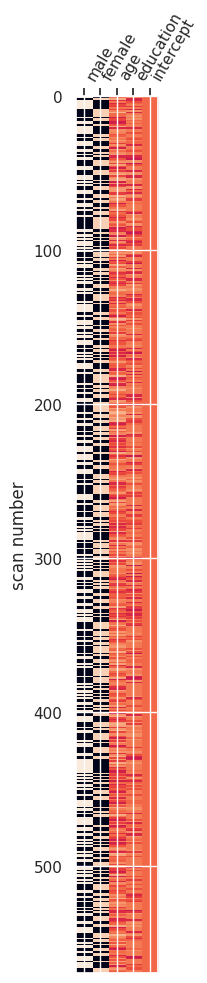

In [7]:
female_contrast = []
male_contrast = []

for i in range(0,len(Final_df["Gender"])):
    if Final_df["Gender"][i] == 0:
        male_contrast.append(1)
        female_contrast.append(0)
        
    elif Final_df["Gender"][i] == 1:
        male_contrast.append(0)
        female_contrast.append(1)
        
        
diff_sex = pd.DataFrame(
    {"subject_label" : Final_df["subject_label"],
     "male" : male_contrast,
     "female" : female_contrast,
     "age" : Final_df["Age_in_Yrs"],
     "education" : Final_df["SSAGA_Educ"]
    }
)


design_matrix_sex = glm.second_level.make_second_level_design_matrix(Final_df["subject_label"], diff_sex)
plotting.plot_design_matrix(design_matrix_sex)


In [8]:
models_sex = []
gray_masker = datasets.load_mni152_gm_mask()
seed = ["opIFG_L", "planumtemp_L", "aMTG_L", "pITG_L", "opIFG_R", "planumtemp_R", "aMTG_R", "pITG_R"]
img_tpl = "/data/brambati/dataset/HCP/derivatives/seed-to-voxel-nilearn/results_3D/{seed_name}/sub-{participant_id}/sub-{participant_id}_seed-{seed_name}_mean-4_voxelcorrelations.nii.gz"

for seeds in seed:
    maps = []
    for sub in Final_df["subject_label"]:
        img_path = img_tpl.format(seed_name=seeds, participant_id=sub)
        maps.append(img_path)

    glm_model = SecondLevelModel(mask_img=gray_masker)
    glm_model = glm_model.fit(maps, design_matrix=design_matrix_sex)
    models_sex.append(glm_model)

In [18]:
# run this only one if you don't have the z maps
seed = ["opIFG_L", "planumtemp_L", "aMTG_L", "pITG_L", "opIFG_R", "planumtemp_R", "aMTG_R", "pITG_R"]

for i in range(0, len(models_sex)):
    
    z_map = models_sex[i].compute_contrast(second_level_contrast=[1,-1,0,0,0], output_type="z_score")
    map_tpl = "/home/xlajoie/Desktop/z_maps/z_map_{seed_name}.nii"
    # map_tpl = "/data/brambati/dataset/HCP/derivatives/seed-to-voxel-nilearn/results_2024/z_map_{seed_name}.nii"
    map_path = map_tpl.format(seed_name=seed[i])
    nb.save(z_map, map_path)  

/home/xlajoie/Desktop/z_maps/z_map_opIFG_L.nii
/home/xlajoie/Desktop/z_maps/z_map_planumtemp_L.nii
/home/xlajoie/Desktop/z_maps/z_map_aMTG_L.nii
/home/xlajoie/Desktop/z_maps/z_map_pITG_L.nii
/home/xlajoie/Desktop/z_maps/z_map_opIFG_R.nii
/home/xlajoie/Desktop/z_maps/z_map_planumtemp_R.nii
/home/xlajoie/Desktop/z_maps/z_map_aMTG_R.nii
/home/xlajoie/Desktop/z_maps/z_map_pITG_R.nii


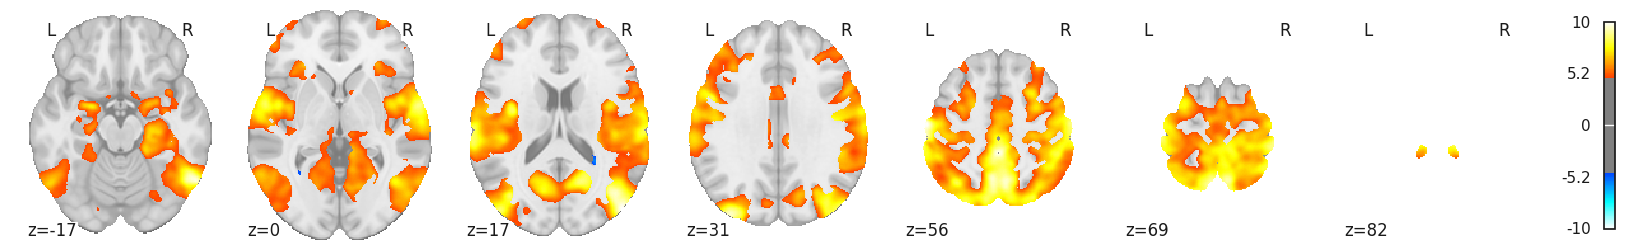

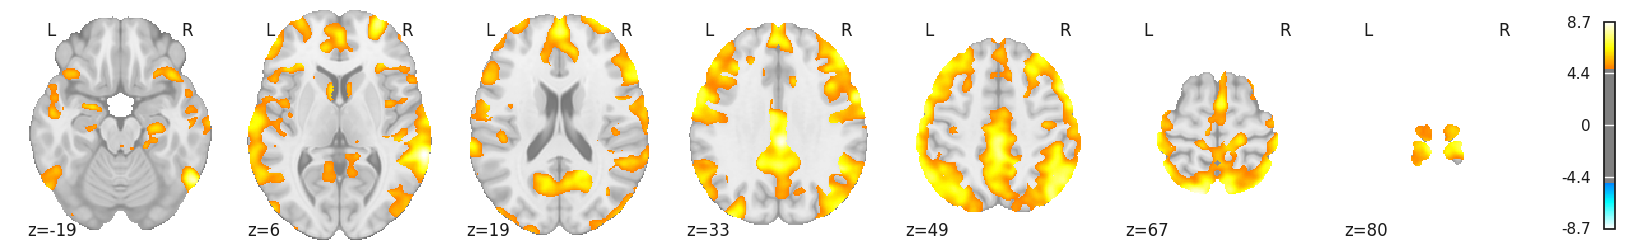

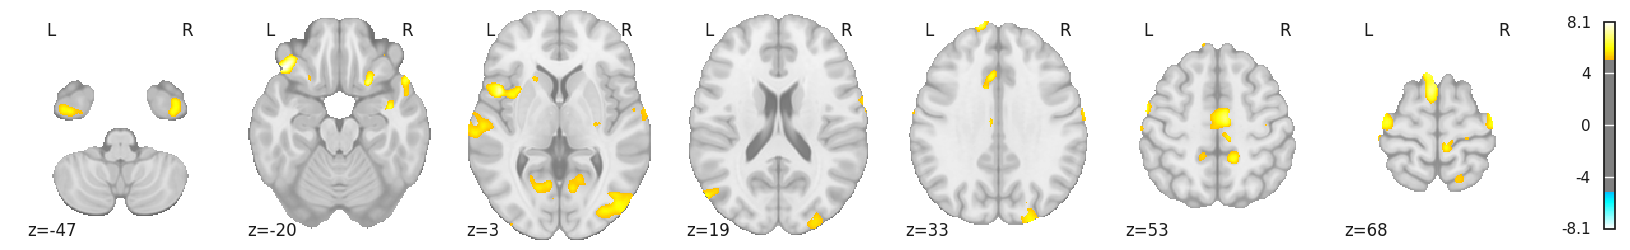

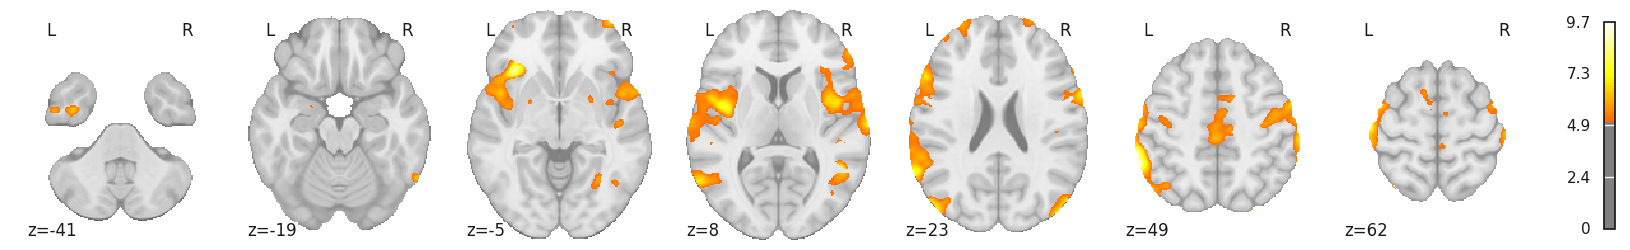

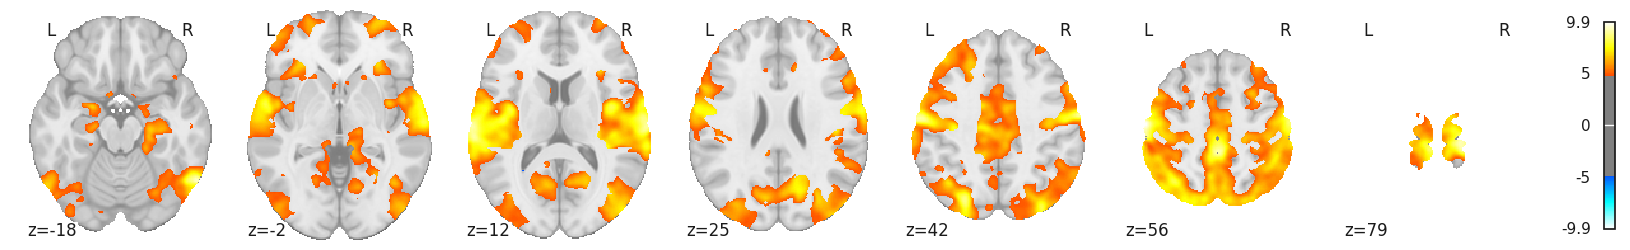

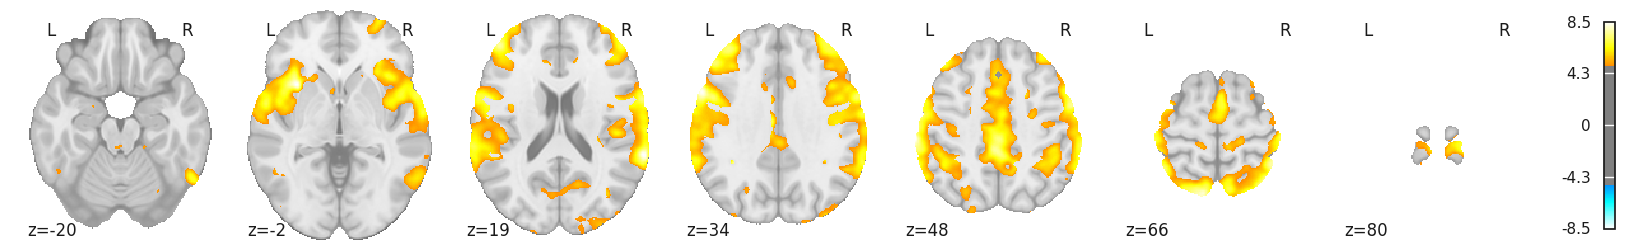

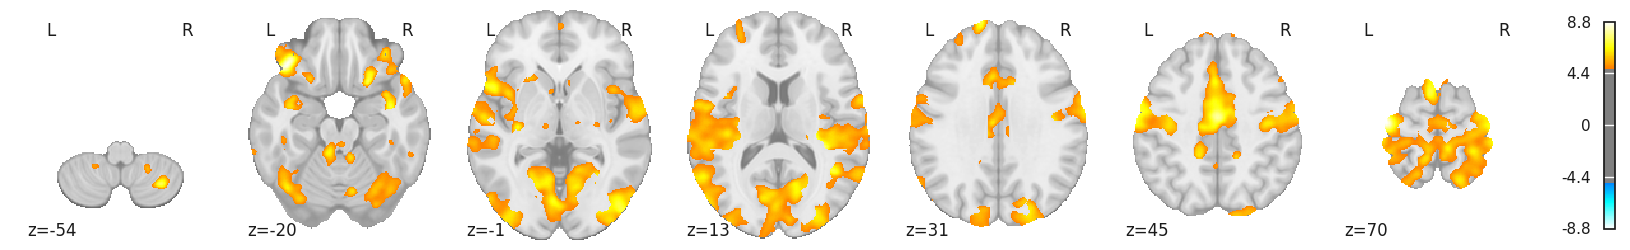

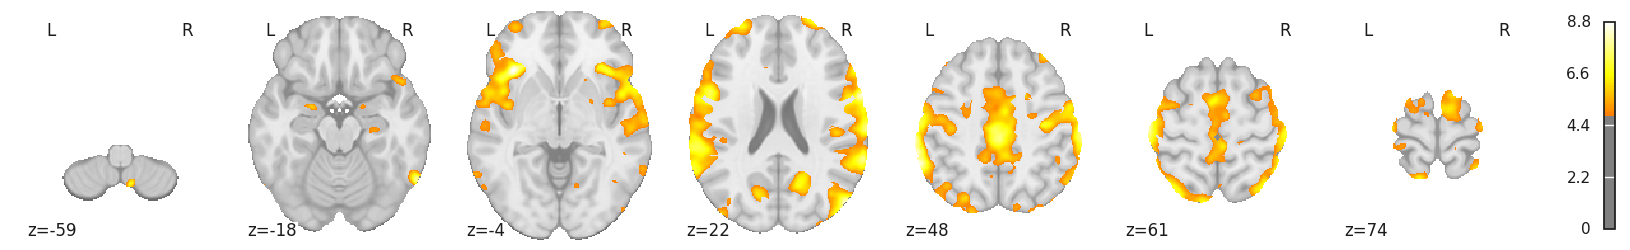

In [24]:
seeds = ["opIFG_L", "planumtemp_L", "aMTG_L", "pITG_L", "opIFG_R", "planumtemp_R", "aMTG_R", "pITG_R"]

for seed in seeds:
    map_tpl = "/home/xlajoie/Desktop/z_maps/z_map_{seed_name}.nii"
    z_map = map_tpl.format(seed_name=seed)
    clean_map, threshold = threshold_stats_img(z_map,
                                               alpha = 0.000005,
                                               height_control="fdr",
                                               cluster_threshold=10)
    
    plotting.plot_stat_map(clean_map,
                           threshold = threshold,
                           colorbar=True,
                           display_mode="z")

    plotting.show()

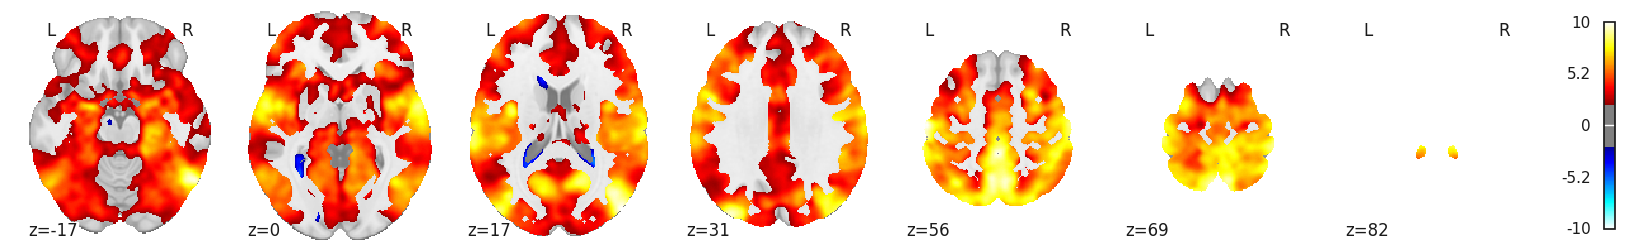

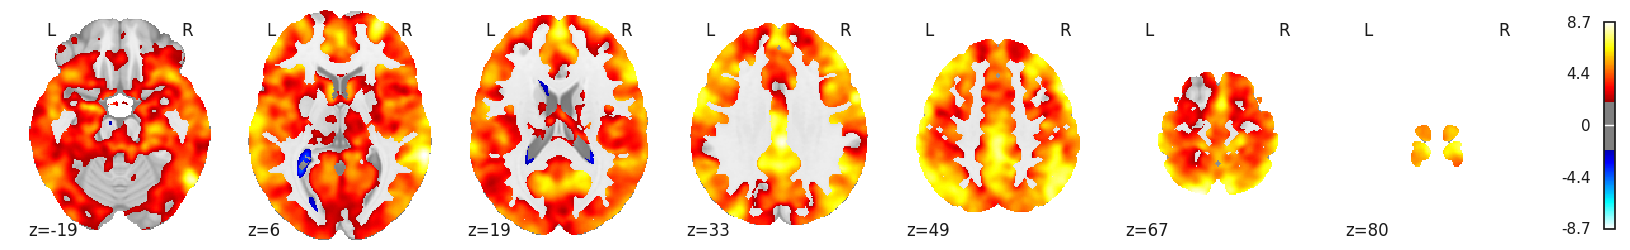

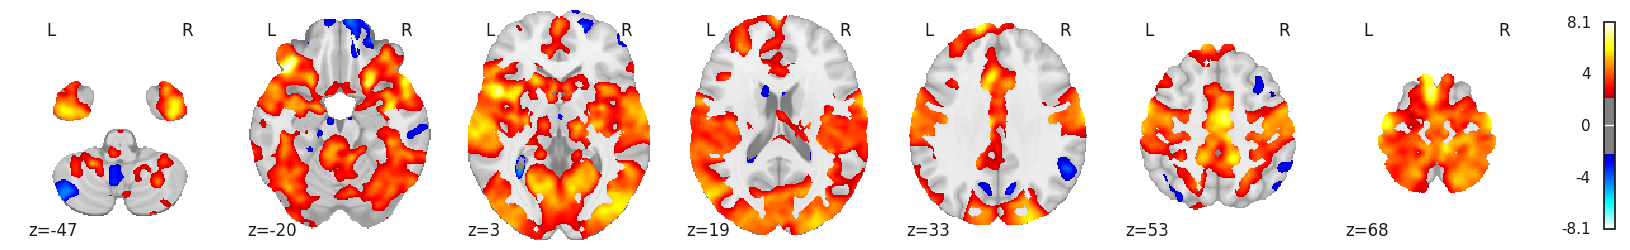

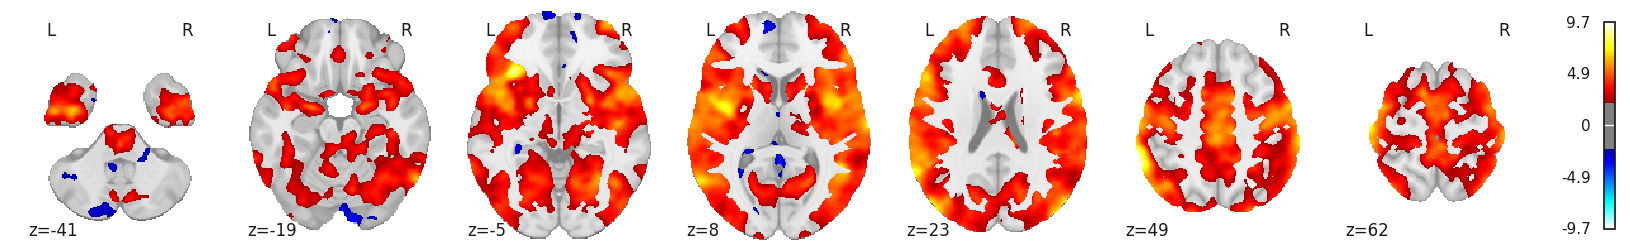

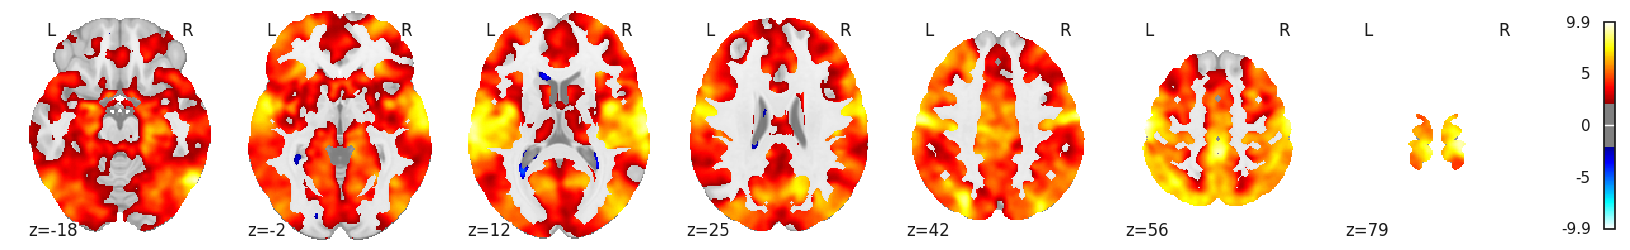

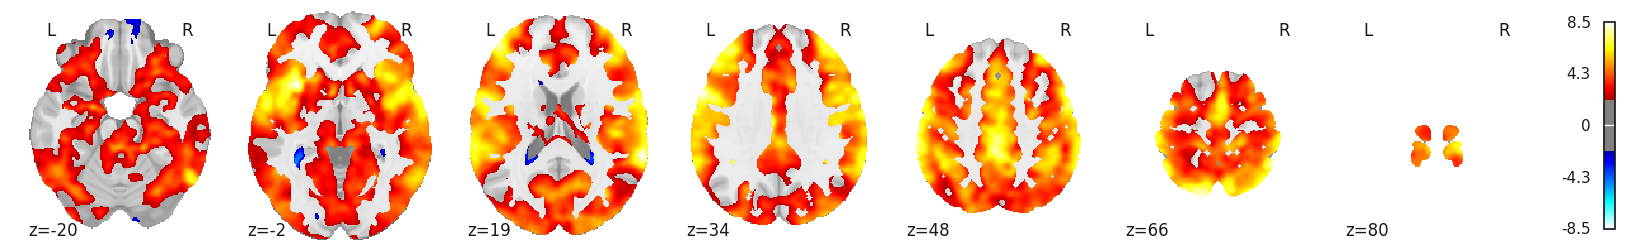

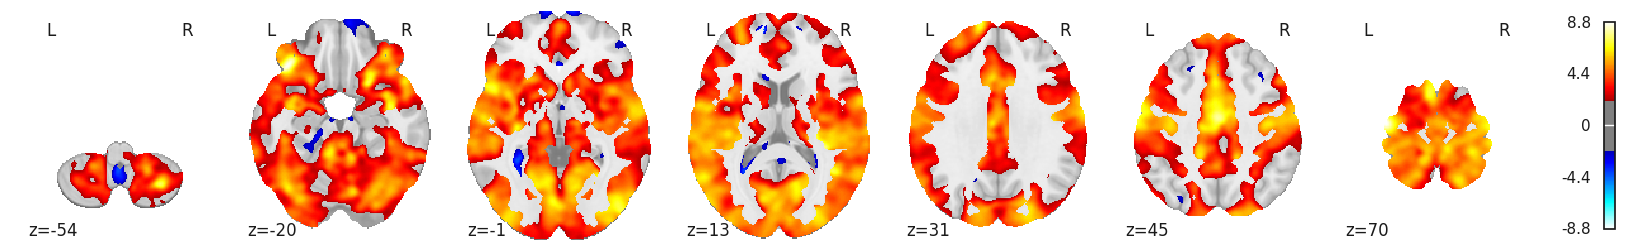

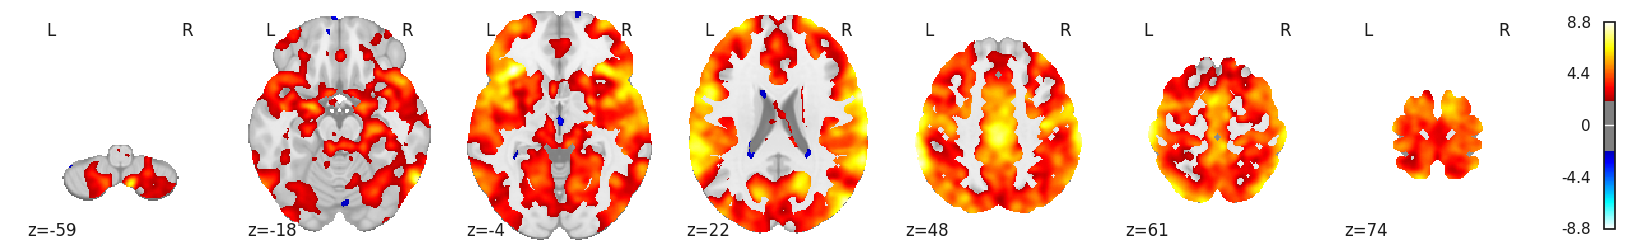

In [23]:
seeds = ["opIFG_L", "planumtemp_L", "aMTG_L", "pITG_L", "opIFG_R", "planumtemp_R", "aMTG_R", "pITG_R"]

for seed in seeds:
    map_tpl = "/home/xlajoie/Desktop/z_maps/z_map_{seed_name}.nii"
    z_map = map_tpl.format(seed_name=seed)
    clean_map, threshold = threshold_stats_img(z_map,
                                               alpha = 0.05,
                                               height_control="fdr",
                                               cluster_threshold=10)
    
    plotting.plot_stat_map(clean_map,
                           threshold = threshold,
                           colorbar=True,
                           display_mode="z")

    plotting.show()

## FWE (Family-Wise Error Rate)

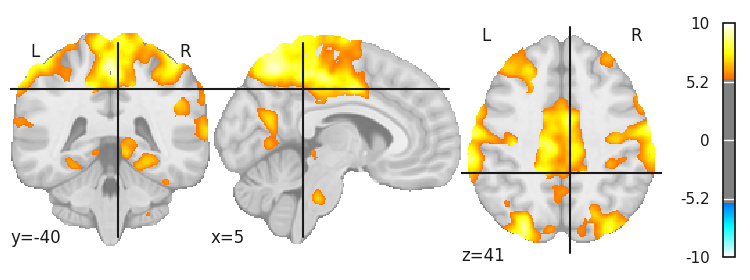

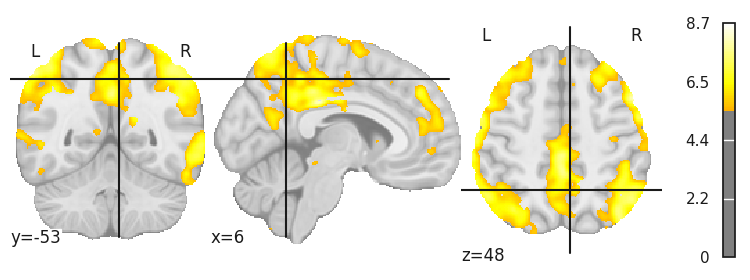

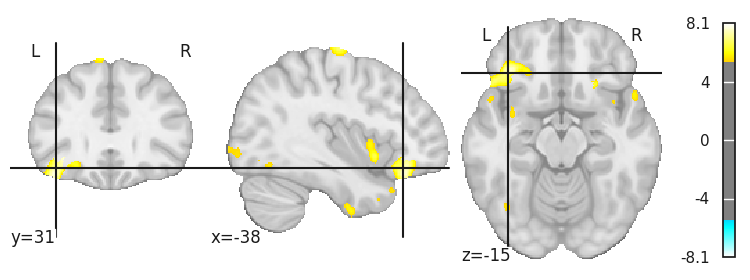

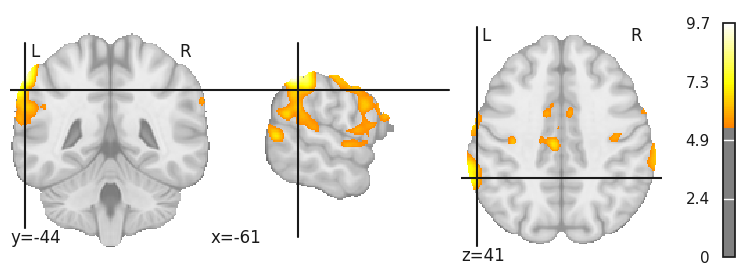

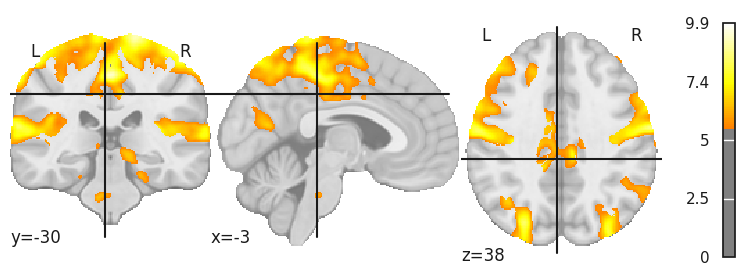

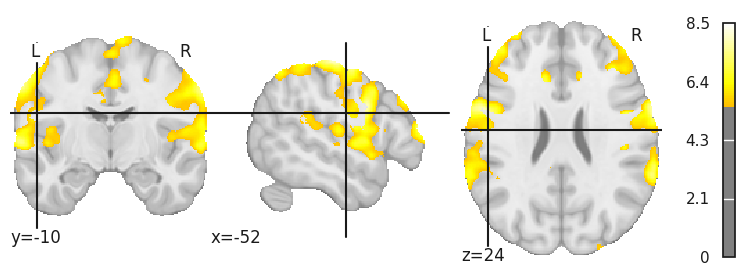

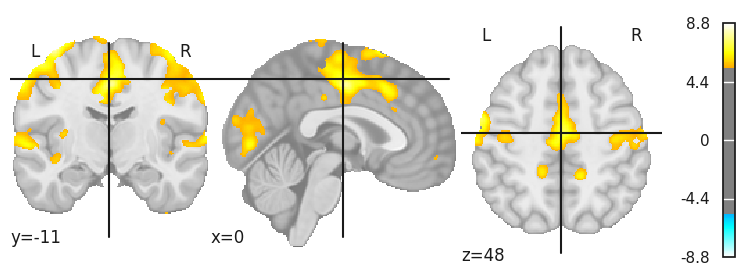

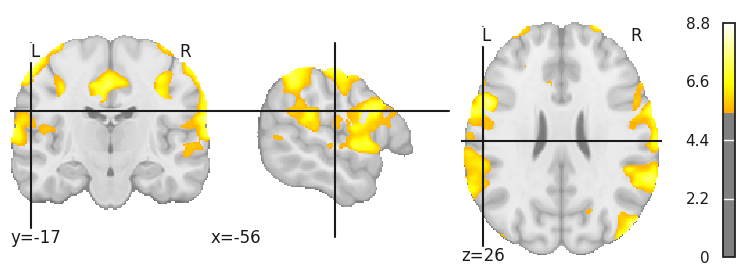

In [12]:
seeds = ["opIFG_L", "planumtemp_L", "aMTG_L", "pITG_L", "opIFG_R", "planumtemp_R", "aMTG_R", "pITG_R"]

for seed in seeds:
    map_tpl = "/home/xlajoie/Desktop/z_maps/z_map_{seed_name}.nii"
    z_map = map_tpl.format(seed_name=seed)
    clean_map, threshold = threshold_stats_img(z_map,
                                               alpha = 0.05,
                                               height_control="bonferroni",
                                               cluster_threshold=10)
    
    plotting.plot_stat_map(clean_map,
                           threshold = threshold,
                           colorbar=True,
                           display_mode="ortho")

    plotting.show()

In [ ]:
## Male brainseed = ["opIFG_L", "planumtemp_L", "aMTG_L", "pITG_L", "opIFG_R", "planumtemp_R", "aMTG_R", "pITG_R"]

for i in range(0, len(models_sex)):
    
    z_map = models_sex[i].compute_contrast(second_level_contrast=[1,-1,0,0,0], output_type="z_score")
    map_tpl = "/home/xlajoie/Desktop/z_maps/z_map_{seed_name}.nii"
    # map_tpl = "/data/brambati/dataset/HCP/derivatives/seed-to-voxel-nilearn/results_2024/z_map_{seed_name}.nii"
    map_path = map_tpl.format(seed_name=seed[i])
    nb.save(z_map, map_path)

## Z maps for male

In [ ]:
# TODO to run at home

seed = ["opIFG_L", "planumtemp_L", "aMTG_L", "pITG_L", "opIFG_R", "planumtemp_R", "aMTG_R", "pITG_R"]

for i in range(0, len(models_sex)):
    
    z_map = models_sex[i].compute_contrast(second_level_contrast=[1,0,0,0,0], output_type="z_score")
    map_tpl = "/data/brambati/dataset/HCP/derivatives/z_maps_man/z_map_{seed_name}.nii"
    # map_tpl = "/data/brambati/dataset/HCP/derivatives/seed-to-voxel-nilearn/results_2024/z_map_{seed_name}.nii"
    map_path = map_tpl.format(seed_name=seed[i])
    nb.save(z_map, map_path)

## Z maps for female

In [ ]:
# TODO to run at home

seed = ["opIFG_L", "planumtemp_L", "aMTG_L", "pITG_L", "opIFG_R", "planumtemp_R", "aMTG_R", "pITG_R"]

for i in range(0, len(models_sex)):
    
    z_map = models_sex[i].compute_contrast(second_level_contrast=[0,1,0,0,0], output_type="z_score")
    map_tpl = "/data/brambati/dataset/HCP/derivatives/z_maps_female/z_map_{seed_name}.nii"
    # map_tpl = "/data/brambati/dataset/HCP/derivatives/seed-to-voxel-nilearn/results_2024/z_map_{seed_name}.nii"
    map_path = map_tpl.format(seed_name=seed[i])
    nb.save(z_map, map_path)